### lab_4
### POS disambibuation with CRF

Даша Игнатенко


In [110]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV


import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

import os
import pyconll

Данные: UD SynTagRus

https://universaldependencies.org/treebanks/ru_syntagrus/index.html

In [2]:
train = pyconll.load_from_file("ru_syntagrus-ud-train-a.conllu")

In [3]:
test = pyconll.load_from_file("ru_syntagrus-ud-test.conllu")

In [4]:
for sent in train[:2]:
    for token in sent:
        print(token.form, token.upos)
    print()

Анкета NOUN
. PUNCT

Начальник NOUN
областного ADJ
управления NOUN
связи NOUN
Семен PROPN
Еремеевич PROPN
был AUX
человек NOUN
простой ADJ
, PUNCT
приходил VERB
на ADP
работу NOUN
всегда ADV
вовремя ADV
, PUNCT
здоровался VERB
с ADP
секретаршей NOUN
за ADP
руку NOUN
и CCONJ
иногда ADV
даже PART
писал VERB
в ADP
стенгазету NOUN
заметки NOUN
под ADP
псевдонимом NOUN
" PUNCT
Муха NOUN
" PUNCT
. PUNCT



In [96]:
# извлечение features для каждого слова
def word_features(sentence, i):
	word = str(sentence[i].form)
	features = {
		'word': word,
		'is_first': i == 0, #1 слово в предложении
		'is_last': i == len(sentence) - 1, #последнее
		'is_capitalized': word[0].upper() == word[0],
		'is_all_caps': word.upper() == word,	 #uppercase
		'is_all_lower': word.lower() == word,	 #lowercase
		#префикс
		'prefix-1': word[0], 
		'prefix-2': word[:2],
		'prefix-3': word[:3],
		#суффикс
		'suffix-1': word[-1],
		'suffix-2': word[-2:],
		'suffix-3': word[-3:],
		#предыдущее слово
		'prev_word': '' if i == 0 else sentence[i-1].form,
		#следующее слово
		'next_word': '' if i == len(sentence)-1 else sentence[i+1].form,
		'has_hyphen': '-' in word, #есть ли дефис
		'is_numeric': word.isdigit(),
		'capitals_inside': word[1:].lower() != word[1:]
	}
	return features

In [97]:
#извлекаем features для каждого предложения
def sent_features(data):
    X = []
    y = []
    for sentence in train:
    	X_sentence = []
    	y_sentence = []
    	for i in range(len(sentence)):
    		X_sentence.append(word_features(sentence, i))
    		y_sentence.append(str(sentence[i].upos))
    	X.append(X_sentence)
    	y.append(y_sentence)
    return X,y

In [98]:
X_train, y_train = sent_features(train)

In [99]:
X_test, y_test = sent_features(test)

In [100]:
#CRF model
crf = sklearn_crfsuite.CRF(
	algorithm='lbfgs',
	c1=0.1,
	c2=0.1,
	max_iterations=100,
	all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

In [101]:
y_pred = crf.predict(X_test)

In [102]:
print(metrics.flat_accuracy_score(y_test, y_pred))

0.9936388679015069


In [103]:
labels = list(crf.classes_)

In [ ]:
from sklearn_crfsuite.utils import flatten
from sklearn import metrics as skmetrics

In [104]:
y_test_flat = flatten(y_test)
y_pred_flat = flatten(y_pred)
    
print(skmetrics.classification_report(y_test_flat, y_pred_flat))

              precision    recall  f1-score   support

         ADJ       0.99      0.99      0.99     43357
         ADP       1.00      1.00      1.00     39344
         ADV       0.98      0.98      0.98     22733
         AUX       0.97      0.97      0.97      3537
       CCONJ       0.98      0.99      0.99     15168
         DET       0.99      0.98      0.98     10781
        INTJ       0.98      0.94      0.96        50
        NOUN       1.00      1.00      1.00    103538
         NUM       0.99      0.99      0.99      5640
        None       1.00      1.00      1.00       521
        PART       0.98      0.97      0.98     13556
        PRON       0.98      0.98      0.98     18734
       PROPN       1.00      1.00      1.00     14854
       PUNCT       1.00      1.00      1.00     77972
       SCONJ       0.94      0.98      0.96      8057
         SYM       1.00      1.00      1.00       420
        VERB       1.00      0.99      0.99     47731
           X       1.00    

Посмотрим, с чем модель не справляется

In [31]:
!pip install highlight_text

In [32]:
import matplotlib.pyplot as plt
import matplotlib
from highlight_text import HighlightText, ax_text, fig_text
import random

In [111]:
text = ''
color = []
for s in range(len(X_test)):
    if s == 50:
        break
    for w in range(len(X_test[s])):
        if y_test[s][w] != y_pred[s][w]:
            word = '<' + str(X_test[s][w]['word']) + '>'
            color.append({"color": 'magenta'})
            print(y_test[s][w])
            print(y_pred[s][w])
            print(X_test[s][w])
        else:
            word = str(X_test[s][w]['word'])
        text = text + word + ' '
    text += '\n'

NOUN
ADJ
{'word': 'Приемная', 'is_first': True, 'is_last': False, 'is_capitalized': True, 'is_all_caps': False, 'is_all_lower': False, 'prefix-1': 'П', 'prefix-2': 'Пр', 'prefix-3': 'При', 'suffix-1': 'я', 'suffix-2': 'ая', 'suffix-3': 'ная', 'prev_word': '', 'next_word': 'была', 'has_hyphen': False, 'is_numeric': False, 'capitals_inside': False}
ADV
PART
{'word': 'просто', 'is_first': False, 'is_last': False, 'is_capitalized': False, 'is_all_caps': False, 'is_all_lower': True, 'prefix-1': 'п', 'prefix-2': 'пр', 'prefix-3': 'про', 'suffix-1': 'о', 'suffix-2': 'то', 'suffix-3': 'сто', 'prev_word': 'обставлена', 'next_word': ',', 'has_hyphen': False, 'is_numeric': False, 'capitals_inside': False}
ADV
SCONJ
{'word': 'как', 'is_first': False, 'is_last': False, 'is_capitalized': False, 'is_all_caps': False, 'is_all_lower': True, 'prefix-1': 'к', 'prefix-2': 'ка', 'prefix-3': 'как', 'suffix-1': 'к', 'suffix-2': 'ак', 'suffix-3': 'как', 'prev_word': ',', 'next_word': 'будто', 'has_hyphen': Fa

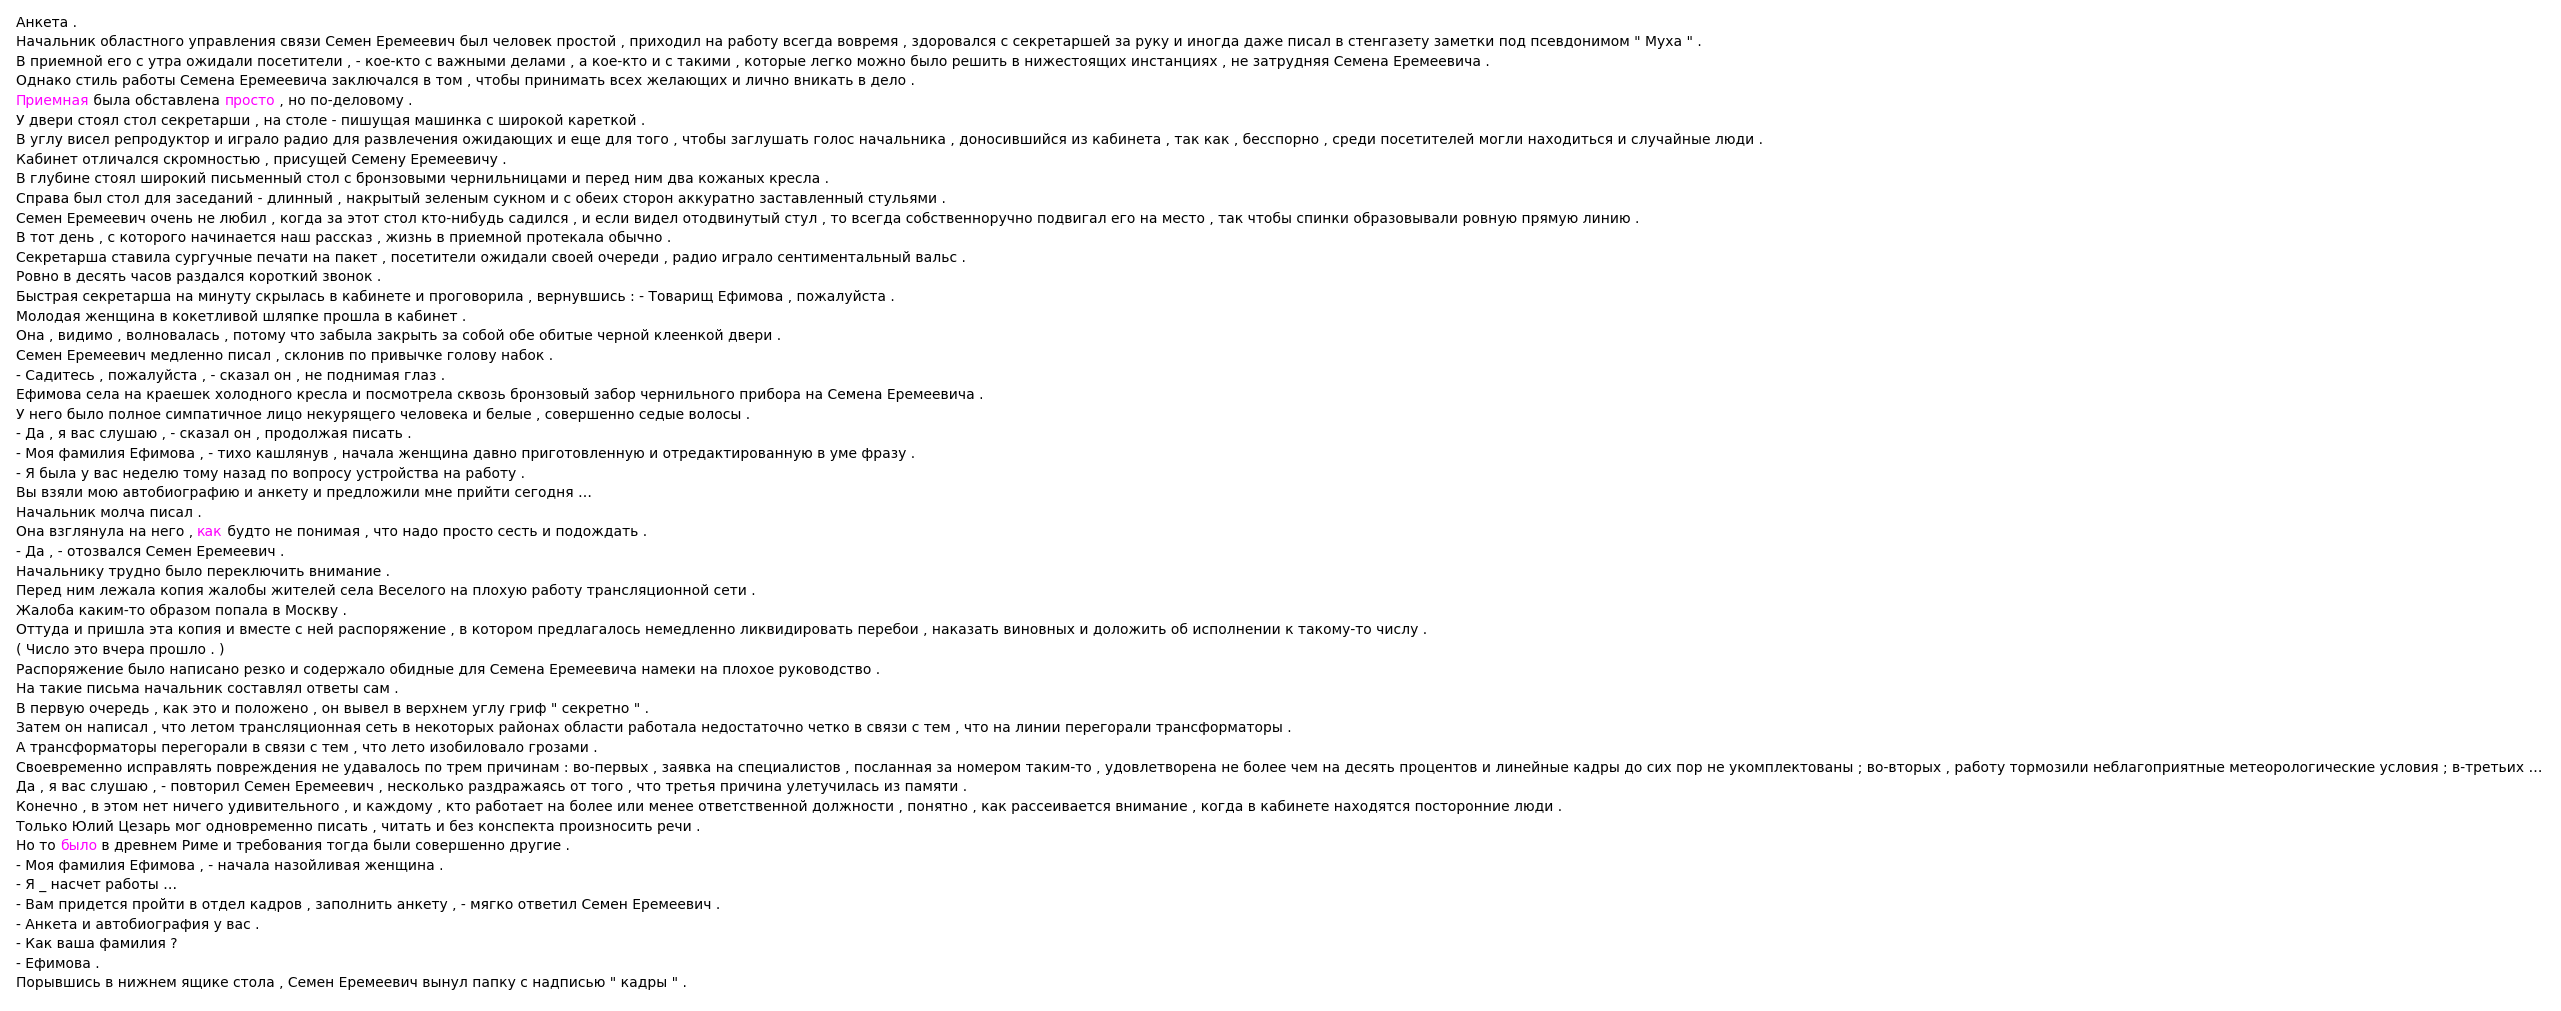

In [112]:
font = {'family' : 'DejaVu Sans',
        'size'   : 10}
matplotlib.rc('font', **font)
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

# You can either create a HighlightText object
HighlightText(x=0, y=1,
              s=text,
              highlight_textprops=color,
              ax=ax)



In [91]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [108]:
cm = confusion_matrix(y_test_flat, y_pred_flat)

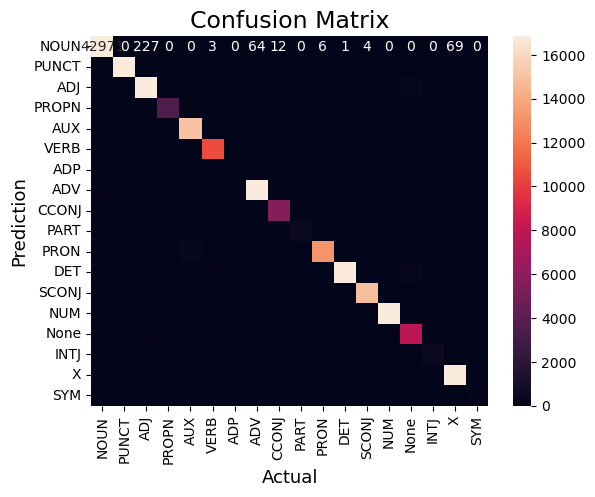

In [109]:
sns.heatmap(cm, 
			annot=True,
			fmt='g', 
			xticklabels=list(crf.classes_),
			yticklabels=list(crf.classes_), robust=True)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()